# As entradas do programa Achilles: Fração de Areia e Densidade Aparente Seca


## Aba simulação de COT:

A primeira entrada requisitada chama-se fração areia. Ela é calculada por meio do dado de Vshale calculado anteriormente. 

O modelo de fração areia considera um poço formado por apenas duas componentes litológicas: folhelho e arenito. Aonde as duas componentes são complementares entre si. 

E obedecem a mesma regra de formação definida pela função SandFraction.

In [8]:
######################PACOTES##########################
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
import lasio
import seaborn as sns
from IPython.display import display
from PIL import Image
sys.path.insert(0,'../modules')
from graficador import plotagem as plm2
#######################################################

In [3]:
def igr(GR):
    #Definidos através de normalização minmax
    GRmin=min(GR)
    GRmax=max(GR)
    IGR = np.zeros(np.size(GR))
    IGR = (GR-GRmin)/(GRmax-GRmin)
    return IGR

In [4]:
def clavier(IGR):
    VSH = np.zeros(np.size(IGR))
    VSH = 1.7 - np.sqrt(3.38-(IGR+0.7)**2.0)
    return VSH

In [5]:
def SandFraction(VSH):
    SF= (1-VSH) * 100
    return SF

A segunda entrada corresponde a Densidade Aparente Seca. Ela é calculada pelo operador diferença entre o canal de densidade total e de densidade neutrônica. 

Ele é definido pela função Densidade Aparente Seca.

In [6]:
def DensidadeAparenteSeca(RHOB,NPHI):
    NPHI= NPHI / 100 # Fator de conversão
    DAS=RHOB-NPHI
    return DAS

# Dado de Entrada

In [9]:
las = lasio.read("../inputs/1SES-0173--SE-.las")
las.sections.keys()
las.sections['Version']
for item in las.sections['Well']:
    print(f"{item.descr} ({item.mnemonic}): \t\t {item.value}")
    
    
las.sections['Well']['WELL'] = 'Brasil'

for count, curve in enumerate(las.curves):
    print(f"Curve: {curve.mnemonic}, \t Units: {curve.unit}, \t Description: {curve.descr}")
print(f"There are a total of: {count+1} curves present within this file")

Start Depth (STRT): 		 2891.0
Stop Depth (STOP): 		 6549.51
Step (STEP): 		 0.1524
Null Value (NULL): 		 -99999.0
Company (COMP): 		 PETROLEO BRASILEIRO S/A
Origem dos dados (ORIG): 		 SIGEO EXPORTACAO PERFIL
Well (WELL): 		 1SES 0173  SE
Field (FLD): 		 
State (STAT): 		 SERGIPE
API Code (API): 		 901210520900
API Code (UWI): 		 901210520900
Surface X (XCOORD): 		 758643.0
Surface Y (YCOORD): 		 8723117.0
Horizontal Coordinate System (HZCS): 		 UTM
Meridiano Central (MC): 		 39 W
Latitude (LAT): 		 -11.541114
Longitude (LONG): 		 -36.62862
Geodetic Datum (GDAT): 		 SIRGAS2000
Elevation Derrick Floor (EDF): 		 25.0
Water Depth to Mean Sea Level (WDMS): 		 2820.0
Curve: DEPT, 	 Units: M, 	 Description: Measured Depth
Curve: COTA, 	 Units: M, 	 Description: Vertical Depth (without EKB)
Curve: TVD, 	 Units: M, 	 Description: Vertical Depth
Curve: COORDEW, 	 Units: , 	 Description: Coordinate East/West
Curve: COORDNS, 	 Units: , 	 Description: Coordinate North/South
Curve: BRGR, 	 Units: g

In [10]:
#----------------------------------------------------------------------#
# Leitura do data frame que contém os canais da perfilagem             #
#----------------------------------------------------------------------#
df = pd.read_csv("../inputs/1SES-0173--SE-.las", sep='\s+', skiprows=38, 
                 names=('Depth(m)','Cota','TVD','Lat','Long',
                        'BRGR.gAPI','BRNEUT.%','BRDENS.g/cm3','BRDTP.us/ft','BRCALI.in'))

In [11]:
#Filtra os Nan:
df=df[(df['BRGR.gAPI'] != -99999.0)]
df=df[(df['BRNEUT.%'] != -99999.0)]
df=df[(df['BRDENS.g/cm3'] != -99999.0)]

In [12]:
#Analisa a presença de valores negativos em GR
df.describe()

,Depth(m),Cota,TVD,Lat,Long,BRGR.gAPI,BRNEUT.%,BRDENS.g/cm3,BRDTP.us/ft,BRCALI.in
count,12599.000000,12599.000000,12599.000000,12599.000000,1.259900e+04,12599.000000,12599.000000,12599.000000,12599.000000,12599.000000
mean,5569.695536,-5543.943816,5568.943816,758655.560456,8.723161e+06,76.952890,16.530700,2.574204,82.990536,9.873147
std,560.731205,560.320368,560.320368,7.365529,1.892366e+01,25.164279,8.238244,0.102253,15.094351,1.739702
min,4599.099200,-6508.668400,4599.007100,758641.680000,8.723130e+06,11.304000,0.319600,1.782600,49.513800,8.160500
25%,5079.083000,-6029.367800,5078.652900,758649.120000,8.723146e+06,61.128450,9.733750,2.508100,71.287650,8.556500
50%,5575.373600,-5549.630000,5574.630000,758657.970000,8.723161e+06,81.570900,15.616700,2.591800,79.334200,8.698900
75%,6055.357400,-5053.652900,6054.367800,758662.730000,8.723174e+06,93.521600,23.345250,2.647600,95.476500,12.078100
max,6535.341200,-4574.007100,6533.668400,758662.830000,8.723200e+06,461.944600,60.686200,2.857500,119.955500,18.094800


In [13]:
#Vetoriza as variáveis
prof=np.array(df['Depth(m)'])
tvd=np.array(df['TVD'])
GR=np.array(df['BRGR.gAPI'])
NPHI=np.array(df['BRNEUT.%'])
RHOB=np.array(df['BRDENS.g/cm3'])

## Teste das funções

In [14]:
#Calculando o índice de GR
IGR = igr(GR)
#Calcula o Vshale:
print(clavier(IGR),np.size(clavier(IGR)),np.size(IGR))
#Calcula a Fração Areia:
print(SandFraction(clavier(IGR)),np.size(SandFraction(clavier(IGR))),np.size(IGR))
#Calcula a Densidade Aparente Seca:
print(DensidadeAparenteSeca(RHOB,NPHI),np.size(DensidadeAparenteSeca(RHOB,NPHI)),np.size(IGR))


[0.02883594 0.03560964 0.0417961  ... 0.07430983 0.07291995 0.06861253] 12599 12599
[97.116406   96.43903614 95.82038991 ... 92.569017   92.70800504
 93.13874734] 12599 12599
[1.482975 1.373535 1.367301 ... 2.567583 2.563807 2.563257] 12599 12599


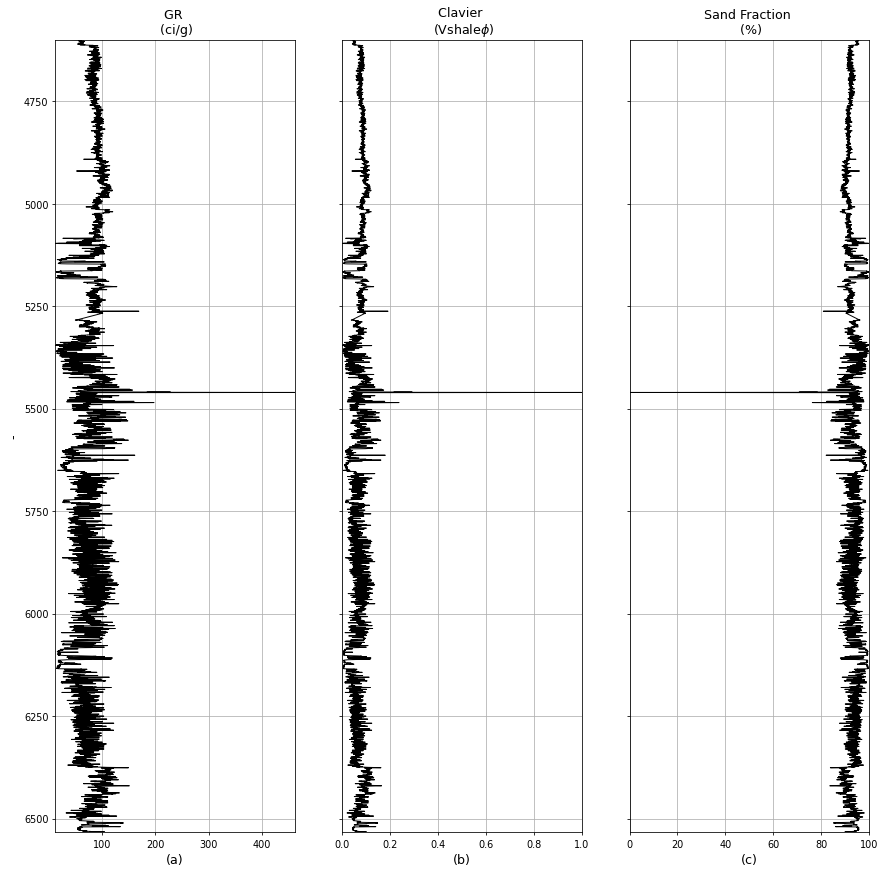

In [15]:
padrao={'comprimento':15,
            'altura':15
}
#Desenha os plots
figure2 = plm2(3, padrao)
figure2.plot_s(0,GR,tvd,{'titulo':'GR \n (ci/g)','cor':'k','descricao_x':'(a)'})
figure2.plot_s(1,clavier(IGR),tvd,{'titulo':'Clavier \n (Vshale$\phi$)','cor':'k','descricao_x':'(b)'})
figure2.plot_s(2,SandFraction(clavier(IGR)),tvd,{'titulo':'Sand Fraction \n (%)','cor':'k','descricao_x':'(c)'})

#figure2.legenda({'ancoragem':(-0.3, 0.09, 3.0, -0.16),'colunas':2,'ordem':[0,1,2,3,4,5,6,7] })

plt.savefig('../images/SandFraction173.png', dpi=300, bbox_inches = 'tight', transparent = True)

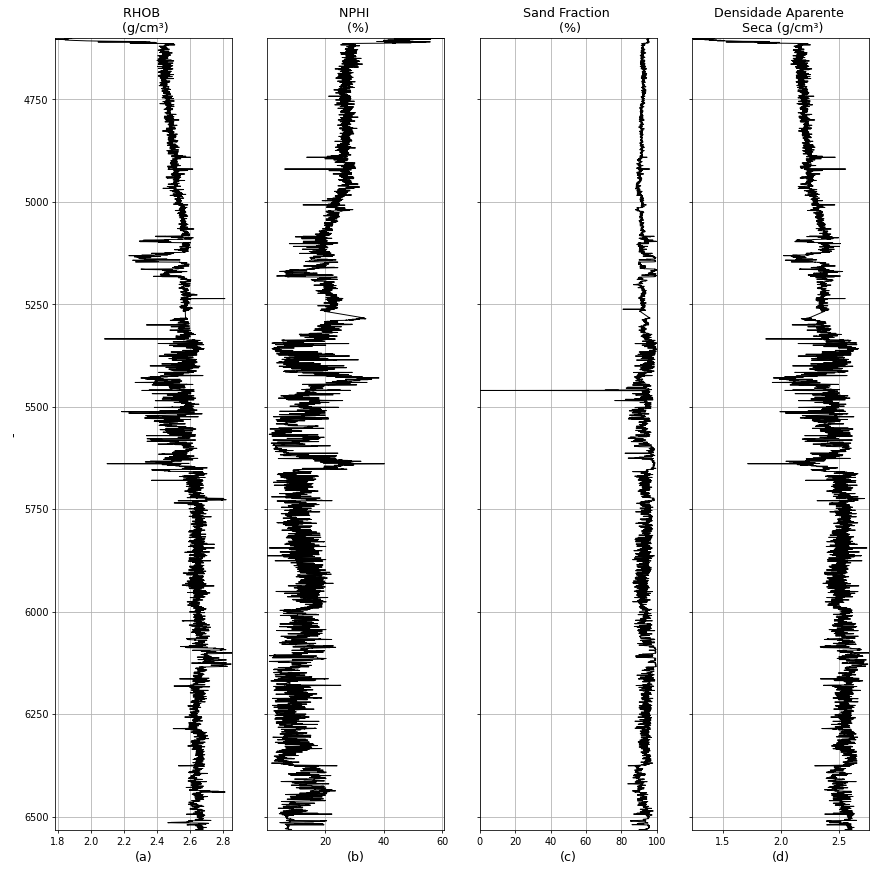

In [17]:
padrao={'comprimento':15,
            'altura':15
}
#Desenha os plots
figure2 = plm2(4, padrao)     
figure2.plot_s(0,RHOB,tvd,{'titulo':'RHOB \n (g/cm³)','cor':'k','descricao_x':'(a)'})
figure2.plot_s(1,NPHI,tvd,{'titulo':'NPHI \n (%)','cor':'k','descricao_x':'(b)'})
figure2.plot_s(2,SandFraction(clavier(IGR)),tvd,{'titulo':'Sand Fraction \n (%)','cor':'k','descricao_x':'(c)'})
figure2.plot_s(3,DensidadeAparenteSeca(RHOB,NPHI),tvd,{'titulo':'Densidade Aparente \n Seca (g/cm³)','cor':'k','descricao_x':'(d)'})

#figure2.legenda({'ancoragem':(-0.3, 0.09, 3.0, -0.16),'colunas':2,'ordem':[0,1,2,3,4,5,6,7] })

plt.savefig('../images/DryDensity173.png', dpi=300, bbox_inches = 'tight', transparent = True)

# FIM